In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sentence_transformers import SentenceTransformer, util
import random
import json
import os
import pickle as pkl
import torch
import openai
from dotenv import load_dotenv
load_dotenv()
from collections import defaultdict

### Khởi tạo model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-tas-b').to(device)

In [4]:
with open("knowledge_graph/KG_data/FB15k-237-betae/id2ent.pkl", "rb") as f:
    id2ent = pkl.load(f)
with open("knowledge_graph/KG_data/FB15k-237-betae/id2rel.pkl", "rb") as f:
    id2rel = pkl.load(f)
with open("knowledge_graph/KG_data/FB15k-237-betae/FB15k_mid2name.txt", "r") as f:
    ent2name = {}
    for line in f:
        mid, name = line.strip().split("\t")
        ent2name[mid] = name

with open("knowledge_graph/queries/train_2c_id.pkl", "rb") as f:
    train_queries = pkl.load(f)
with open("knowledge_graph/KG_data/FB15k-237-betae/valid-hard-answers.pkl", "rb") as f:
    answer_valid_hard = pkl.load(f)

### Tạo embedding cho các relations

In [ ]:
rels = id2rel.values()
rel_embeddings = model.encode(rels)

Nhận xét:  
+ Direct và inverse relation thường có độ khớp gần như nhau.  

Original query:

In [ ]:
query = "Which awards has David Copperfield received for his performances in films?"

#### Query split:  
Do query thể có nhiều phần và cần phải qua nhiều hop mới đạt được kết quả. Do đó, ta có thể đưa query về thành các sub-queries và xử lí từng đoạn.  
+ Splitting queries: Ta có thể đưa LLM làm (PoG có bước này)
+ Compose results: 
    + Sử dụng mean
    + Sử dụng reciprocal rank
    + 

In [ ]:
split_queries = [
    "What films did David Copperfield perform in?",
    "What awards has David Copperfield won?"
]

In [ ]:
split_queries = "Which awards has David Copperfield received for his performances in films?"

In [23]:
query_emb = model.encode(split_queries)

scores = util.dot_score(query_emb, rel_embeddings)

NameError: name 'split_queries' is not defined

### Thử combine 2 relation để so khớp với query.

In [ ]:
def fuse_mean(scores):
    ls = scores.unbind(dim = 0)
    res = torch.zeros(1,scores.shape[1])
    n = scores.shape[0]
    for l in ls:
        res += l / n 
    return res

scores = fuse_mean(scores)

In [ ]:
def fuse_rrf(scores, k=10):
    ls = scores.unbind(dim=0)
    dict_scores = {}
    for l in ls:
        _, indices = torch.sort(l, descending=True)
        for i in range(scores.shape[1]):
            if indices[i].item() not in dict_scores:
                dict_scores[indices[i].item()] = []
            dict_scores[indices[i].item()].append(i + 1)

    for key in dict_scores:
        dict_scores[key] = sum([1/(k + rank) for rank in dict_scores[key]])
    scores = torch.tensor([list(dict_scores.values())])
    return scores
scores = fuse_rrf(scores)

In [ ]:
# scores[0]

In [ ]:
def compare_rel_query_and_return_topk(rels, query, fuse_func=fuse_mean, k=5):
    if type(rels) is not list:
        rels = [rels]
    rels_emb = model.encode(rels)
    query_emb = model.encode([query,])
    scores = util.dot_score(query_emb, rels_emb)
    return return_top_k(scores, rels, k=k, fuse_func=fuse_func)

def return_top_k(scores, rels, k=5, fuse_func=fuse_mean):
    scores = fuse_func(scores)
    sorted_scores, sorted_indices = torch.sort(scores, descending=True)
    for idx in sorted_indices.tolist()[0][:k]:
        print(f"Index: {idx}")
        rel = rels[idx]
        print(f"Relation: {rel}")
        print(f"Score: {scores[0,idx].item()}")
        print("-" * 50)

In [ ]:
c_rel1 = rels[13] + rels[6]
c_rel2 = rels[6] + rels[13]
c_rels = [c_rel1, c_rel2]  # "award_nomination_awarded_to" + "award_winner_award_received"

In [ ]:
compare_rel_query_and_return_topk(c_rels+rels, split_queries, fuse_func=fuse_mean, k=5)

Các relation liên quan tới film dominate


### Inspect queries

In [ ]:
len(train_queries)
random.shuffle(train_queries)
# train_queries_small = train_queries[:100]

In [6]:
queries_small = []
for query in train_queries:
    # if answer_valid_hard.get(query['raw_query'], None) is not None:
    queries_small.append(query)
    if (len(queries_small) >= 100):
        break  
    

In [5]:
with open("knowledge_graph/queries/fail_queries.pkl", "rb") as f:
    fail_id = pkl.load(f)
with open("knowledge_graph/queries/shuffled_queries.pkl", "rb") as f:
    queries_small = pkl.load(f)


In [19]:
with open("knowledge_graph/queries/fail_queries.pkl", "wb") as f:
    pkl.dump(fail_id, f)
with open("knowledge_graph/queries/shuffled_queries.pkl", "wb") as f:
    pkl.dump(queries_small, f)

In [20]:
fail_id

[14, 16, 24, 47, 50, 60, 61, 68, 78, 86, 92, 93, 94, 95]

In [37]:
query= train_queries[0]
query

{'query_type': ('e', ('r', 'r')),
 'raw_query': (4582, (133, 17)),
 'named_query': ('Franklin',
  ('-/people/person/places_lived./people/place_lived/location',
   '-/award/award_nominee/award_nominations./award/award_nomination/award_nominee')),
 'transformed_query': ['Who are the award nominees that have lived in places associated with Franklin?',
  'What are the names of the individuals who were nominated for awards and lived in locations linked to Franklin?',
  'Can you list the award nominees who have resided in locations related to Franklin?'],
 'answers': ['Vince_Gill',
  'Albert_Lee',
  'Keith_Urban',
  'Carrie_Underwood',
  'John_Travolta']}

### Test pipeline extract subgraph

In [38]:
from expand_subgraph import ExpandSubgraph
from utils import  extract_numbers, extract_strings,\
                    extract_notations

In [39]:
expander = ExpandSubgraph(model, util, query, depth=3, k=15)

In [40]:
expander.expand_subgraph(adj_type='direct')
expander.expand_subgraph(adj_type='inverse')

selected_rels: [240, 112]
rel_order: {240: 0, 112: 1}
sorted_triplets: [(4582, 240, 791), (4582, 112, 4582)]
selected_rels: [240, 112, 50]
rel_order: {240: 0, 112: 1, 50: 2}
sorted_triplets: [(4582, 240, 791), (4582, 112, 4582), (791, 50, 62)]
selected_rels: [240, 112, 50]
rel_order: {240: 0, 112: 1, 50: 2}
sorted_triplets: [(4582, 240, 791), (4582, 112, 4582), (791, 50, 62)]
selected_rels: [133, 31, 113, 321]
rel_order: {133: 0, 31: 1, 113: 2, 321: 3}
sorted_triplets: [(4582, 133, 10345), (4582, 133, 2182), (4582, 133, 8412), (4582, 133, 1590), (4582, 31, 3514), (4582, 31, 32), (4582, 113, 4582), (4582, 321, 6419)]
selected_rels: [95, 17, 7, 25, 55, 117, 133, 31, 71, 157, 327, 239, 473, 405, 79]
rel_order: {95: 0, 17: 1, 7: 2, 25: 3, 55: 4, 117: 5, 133: 6, 31: 7, 71: 8, 157: 9, 327: 10, 239: 11, 473: 12, 405: 13, 79: 14}
sorted_triplets: [(2182, 95, 8224), (10345, 95, 9312), (1590, 95, 2201), (1590, 95, 232), (8412, 95, 337), (2182, 17, 2403), (6419, 17, 7530), (6419, 17, 5345), (6419

In [41]:
expander.evaluate_subgraph()

(1.0, 1.0)

In [ ]:
# ExpandSubgraph.dir_adj[4545]

[(262, 4546),
 (176, 11628),
 (262, 13041),
 (326, 13826),
 (262, 4224),
 (262, 13875),
 (262, 382),
 (176, 13875)]

#### Evaluate coverage

**Answer Files Structure:**
+ `valid-easy-answers/test-easy-answers.pkl`: defaultdict(set)
  - Each key represents a query
  - Value represents the answers obtained in the training graph (edges in `train.txt`) / valid graph (edges in `train.txt` + `valid.txt`)

+ `valid-hard-answers/test-hard-answers.pkl`: defaultdict(set)  
  - Each key represents a query
  - Value represents the additional answers obtained in the validation graph (edges in `train.txt` + `valid.txt`) / test graph (edges in `train.txt` + `valid.txt` + `test.txt`)

In [15]:
depths = [3,4,5]
ks = [11,15, 17]


##### Inspect KG properties  
+ Average node degree

In [36]:
dir_adj, inv_adj = expander.build_adjacency_list()

Building adjacency list...


In [54]:
dir_adj[4582]

NameError: name 'dir_adj' is not defined

In [ ]:
s = 0
distribution = defaultdict(int)
for entity in dir_adj:
    s += len(dir_adj[entity])
    distribution[len(dir_adj[entity])] += 1
s / len(dir_adj)

19.745664320441186

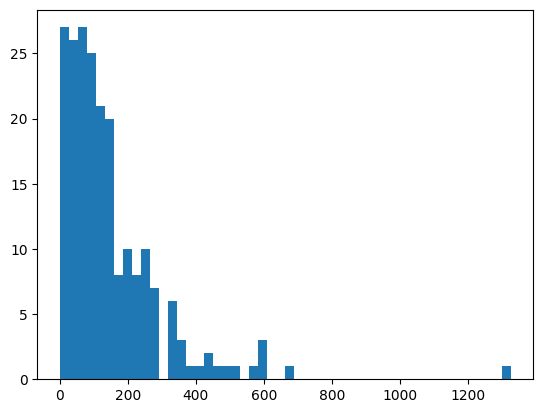

In [56]:
import matplotlib.pyplot as plt
plt.hist(distribution, bins=50);
# plt.xlim(0, 100);

#### Evaluation

In [16]:
results = defaultdict()
type_eval = ["train", "valid"]

for depth in depths:
    for k in ks:
        print(f"Depth: {depth}, K: {k}")
        s_ents_train, s_rels_train = 0, 0
        s_ents_valid, s_rels_valid = 0, 0
        
        # Additional metrics to track
        total_triplets = 0
        total_entities = 0
        total_relations = 0
        expansion_times = []
        failed_expansions = 0
        
        for i, query in enumerate(queries_small):
            try:
                import time
                start_time = time.time()
                
                expander = ExpandSubgraph(model, util, query, depth=depth, k=k)
                expander.expand_subgraph(adj_type='direct')
                expander.expand_subgraph(adj_type='inverse')
                
                expansion_time = time.time() - start_time
                expansion_times.append(expansion_time)
                
                # Get subgraph statistics
                subgraph_triplets = len(expander.subgraph_key['direct']) + len(expander.subgraph_key['inverse'])
                total_triplets += subgraph_triplets
                
                # Count unique entities and relations
                entities_set = set()
                relations_set = set()
                for h, r, t in expander.subgraph_key['direct'] + expander.subgraph_key['inverse']:
                    entities_set.update([h, t])
                    relations_set.add(r)
                
                total_entities += len(entities_set)
                total_relations += len(relations_set)
                
                # Evaluate coverage
                se, sr = expander.evaluate_subgraph(type_eval="train")
                s_ents_train += se
                s_rels_train += sr
                
                se, sr = expander.evaluate_subgraph(type_eval="valid")
                s_ents_valid += se
                s_rels_valid += sr
                
                # Progress indicator
                if (i + 1) % 10 == 0:
                    print(f"  Processed {i+1}/{len(queries_small)} queries")
                    
            except Exception as e:
                failed_expansions += 1
                print(f"  Failed on query {i}: {e}")
        
        # Calculate averages and additional metrics
        n_queries = len(queries_small)
        avg_expansion_time = sum(expansion_times) / len(expansion_times) if expansion_times else 0
        
        results[(depth, k)] = {
            'entity_coverage_train': s_ents_train / n_queries,
            'relation_coverage_train': s_rels_train / n_queries,
            'entity_coverage_valid': s_ents_valid / n_queries,
            'relation_coverage_valid': s_rels_valid / n_queries,
            'avg_triplets_per_query': total_triplets / n_queries,
            'avg_entities_per_query': total_entities / n_queries,
            'avg_relations_per_query': total_relations / n_queries,
            'avg_expansion_time': avg_expansion_time,
            'failed_expansions': failed_expansions,
            'success_rate': (n_queries - failed_expansions) / n_queries
        }
        
        # Print summary for this configuration
        # print(f"  Results: Entity Coverage (train/valid): {results[(depth, k)]['entity_coverage_train']:.3f}/{results[(depth, k)]['entity_coverage_valid']:.3f}")
        # print(f"  Avg triplets: {results[(depth, k)]['avg_triplets_per_query']:.1f}, Avg time: {avg_expansion_time:.2f}s")
        # print(f"  Success rate: {results[(depth, k)]['success_rate']:.3f}")
        # print("=" * 50)

Depth: 3, K: 11
  Processed 10/100 queries
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
  Processed 20/100 queries
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
  Processed 30/100 queries
  Processed 40/100 queries
  Failed on query 47: division by zero
  Processed 50/100 queries
No triplets to expand.
No triplets to expand.
  Processed 60/100 queries
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
No triplets to expand.
 

### Pandas analysis

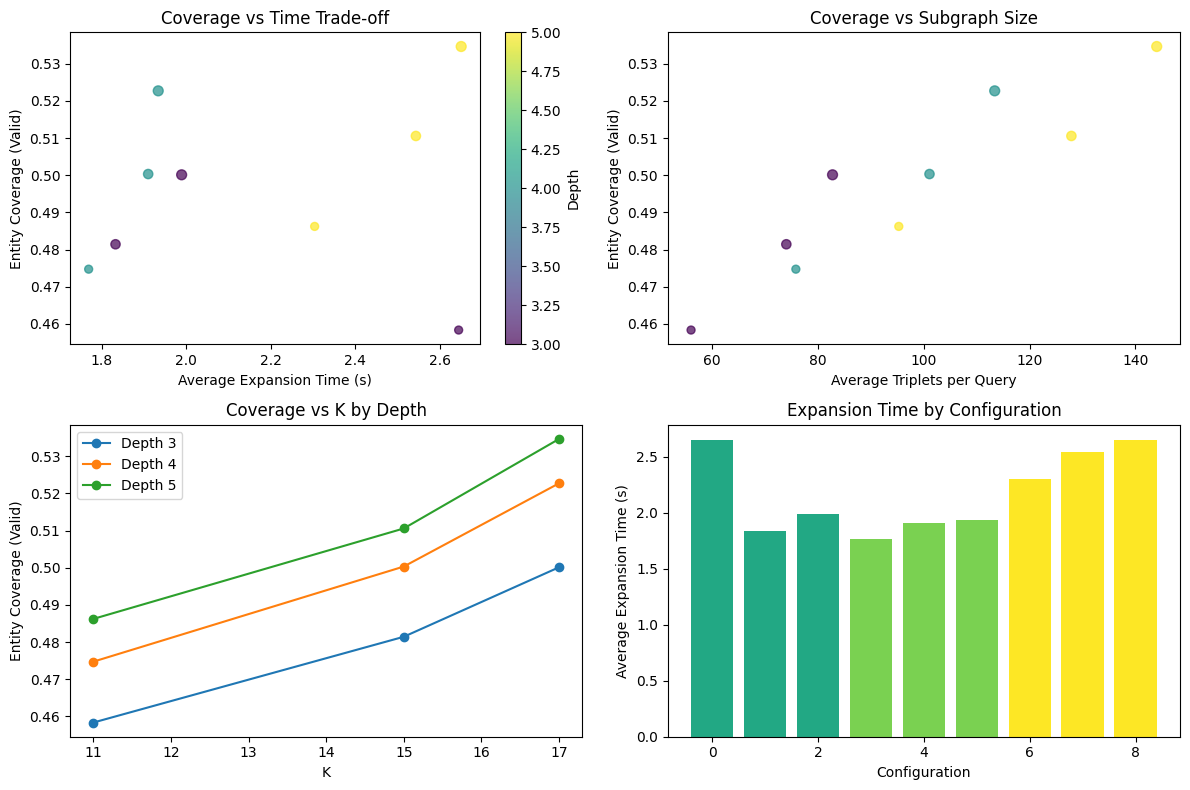

Best configurations:
Best entity coverage (valid):
  Depth: 5.0, K: 17.0, Coverage: 0.535
Best time efficiency (coverage/time):
  Depth: 4.0, K: 17.0, Efficiency: 0.270


In [17]:
# After the main loop, add analysis
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame for easier analysis
df_results = []
for (depth, k), metrics in results.items():
    row = {'depth': depth, 'k': k}
    row.update(metrics)
    df_results.append(row)

df = pd.DataFrame(df_results)

# Plot coverage vs time trade-off
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df['avg_expansion_time'], df['entity_coverage_valid'], 
           c=df['depth'], s=df['k']*3, alpha=0.7)
plt.xlabel('Average Expansion Time (s)')
plt.ylabel('Entity Coverage (Valid)')
plt.title('Coverage vs Time Trade-off')
plt.colorbar(label='Depth')

plt.subplot(2, 2, 2)
plt.scatter(df['avg_triplets_per_query'], df['entity_coverage_valid'],
           c=df['depth'], s=df['k']*3, alpha=0.7)
plt.xlabel('Average Triplets per Query')
plt.ylabel('Entity Coverage (Valid)')
plt.title('Coverage vs Subgraph Size')

plt.subplot(2, 2, 3)
for depth in depths:
    depth_data = df[df['depth'] == depth]
    plt.plot(depth_data['k'], depth_data['entity_coverage_valid'], 
             marker='o', label=f'Depth {depth}')
plt.xlabel('K')
plt.ylabel('Entity Coverage (Valid)')
plt.title('Coverage vs K by Depth')
plt.legend()

plt.subplot(2, 2, 4)
plt.bar(range(len(df)), df['avg_expansion_time'], 
        color=plt.cm.viridis(df['depth']/max(df['depth'])))
plt.xlabel('Configuration')
plt.ylabel('Average Expansion Time (s)')
plt.title('Expansion Time by Configuration')

plt.tight_layout()
plt.show()

# Print best configurations
print("Best configurations:")
print("Best entity coverage (valid):")
best_entity = df.loc[df['entity_coverage_valid'].idxmax()]
print(f"  Depth: {best_entity['depth']}, K: {best_entity['k']}, Coverage: {best_entity['entity_coverage_valid']:.3f}")

print("Best time efficiency (coverage/time):")
df['efficiency'] = df['entity_coverage_valid'] / df['avg_expansion_time']
best_efficiency = df.loc[df['efficiency'].idxmax()]
print(f"  Depth: {best_efficiency['depth']}, K: {best_efficiency['k']}, Efficiency: {best_efficiency['efficiency']:.3f}")

In [22]:
df.head()
df.to_csv("results_22_10.csv", index=False)